In [1]:
import numpy as np
import scipy as sp
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from ipywidgets import interact
from os import path
from scipy.integrate import quad, nquad
from scipy.special import gamma
from scipy.optimize import fsolve
from os import path


In [145]:
# rescaled

mu=10
beta = 3
r= lambda s: s/(2*pi**2)* np.sinh(2*pi*s)
y= lambda s: np.exp(-beta*s**2/2) * 2**(1-2*mu) * np.abs(gamma(mu-0.5+ 1j*s))**2

dz= lambda x: r(x)*y(x)
zmax= 5
Z1= nquad(dz, [[0, zmax]])[0]

def integrand_re(z,R):
    return np.real(r(z)*y(z)/(1-y(z)*R))

def integrand_im(z,R):
    return np.imag(r(z)*y(z)/(1-y(z)*R))


def Zn_calc(R):
    '''Calculates Zn'''
    options={'limit':20}
    integral_re= nquad(integrand_re, [[0, zmax]], args=(R,),opts=[options,options])[0]
    integral_im= nquad(integrand_im, [[0, zmax]], args=(R,),opts=[options,options])[0]
    return integral_re+1j*integral_im



/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (20) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


k/eS0 = 4.00 elapsed time = 6.86 sec


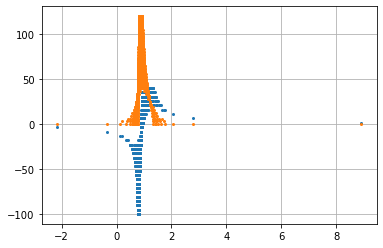

In [3]:

qlist=[4]

plt.figure()

for q in qlist:
#     Rlist_re= np.linspace(-10,8,30) 
    Rlist_re= np.linspace(-100,40,30)
    Rlist_im= np.linspace(0.01,120,40)
    
    t_timer=time.time()

    lmbda_list= np.zeros((len(Rlist_re),len(Rlist_im)), dtype=np.complex128)
    for i_r in range(len(Rlist_re)):
        Rr=Rlist_re[i_r]
        for i_i in range(len(Rlist_im)):
            Ri=Rlist_im[i_i]
            lmbda_list[i_r,i_i]= 1/(1j*Ri+Rr)+Zn_calc(1j*Ri+Rr)*q

    elapsed = time.time() - t_timer
    print("q = %.2f " % (q) + "elapsed time = %.2f " % (elapsed) + "sec")
    inds= np.argwhere(np.abs(np.imag(lmbda_list))<2e-2)
        
    plt.plot(np.real(lmbda_list[inds[:,0],inds[:,1]]),Rlist_re[inds[:,0]],'o',markersize=2)
    plt.plot(np.real(lmbda_list[inds[:,0],inds[:,1]]),Rlist_im[inds[:,1]],'o',markersize=2)
    # plt.ylim(-2e3,8e3)
#     plt.xlim(0.9,1.1)
#     plt.ylim(0,4e3)

plt.grid()
plt.show()

In [18]:
plt.figure()
inds= np.argwhere(np.abs(np.imag(lmbda_list))<1e-3)
# plt.plot(kdS/Z1*np.real(lmbda_list[inds[:,0],inds[:,1]]),Rlist_re[inds[:,0]],'o',markersize=2)
# plt.plot(kdS/Z1*np.real(lmbda_list[inds[:,0],inds[:,1]]),Rlist_im[inds[:,1]],'o',markersize=2)
plt.plot(np.real(lmbda_list[inds[:,0],inds[:,1]]),Rlist_re[inds[:,0]],'o',markersize=2)
plt.plot(np.real(lmbda_list[inds[:,0],inds[:,1]]),Rlist_im[inds[:,1]],'o',markersize=2)
plt.grid()
plt.xlim(0.05,0.2)
plt.show()
# print(Rres_list)

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 432x288 with 0 Axes>

In [104]:
# rescaled solver

from scipy.optimize import root

q=1/16

lmbda_list=np.linspace(0.01,.1,100)*(1+q)
# l2=np.linspace(-1.1,1.1,100)*.0001
# lmbda_list=np.sort(np.concatenate((l1,l2)))

lmbda_res=np.zeros((len(lmbda_list),2))
Rres_re= np.zeros(len(lmbda_list))
Rres_im= np.zeros(len(lmbda_list))
for i_l in range(len(lmbda_list)):
#     print(i_l,end='\r')

    def function(x):
        z=1/(x[0]+1j*x[1]) + Zn_calc(x[0]+1j*x[1])*q-lmbda_list[i_l]
        return np.array([np.real(z),np.imag(z)])
    sol = root(function, np.array([0, 5]), method='hybr', jac = False)

    Rres_re[i_l], Rres_im[i_l] =  sol.x
    lmbda_res[i_l,:]= function(sol.x)

/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (20) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [136]:
inds= np.argwhere(np.abs(lmbda_res[:,1])<1e-4)

num_eigs= np.trapz(np.abs(Rres_im[inds]),x=lmbda_list[inds],axis=0)/pi
tr_rT= 1/(q*Z1)*np.trapz(np.abs(Rres_im[inds])*lmbda_list[inds],x=lmbda_list[inds],axis=0)/pi
vN_ent= -1/(q*Z1)*np.trapz(np.abs(Rres_im[inds])*np.abs(lmbda_list[inds])*np.log(np.abs(lmbda_list[inds])),x=lmbda_list[inds],axis=0)/pi
print('Normalization = ' , num_eigs)
print('trace = ' , tr_rT)
print('vN entropy = ' , vN_ent)
# print((a/b)/Z1*np.abs(Rres_im[inds]))
# print(lmbda_list[inds]*Z1*b/a)

plt.figure(figsize=(4.8,3.6))
plt.plot(lmbda_list[inds],Rres_re[inds],'-',markersize=2)
plt.ylabel('Re R')
plt.xlabel('$\lambda$')
plt.grid()
plt.show()

plt.figure(figsize=(4.8,3.6))
plt.plot(lmbda_list[inds]/(1+q),np.abs(Rres_im[inds]),'o-',markersize=2)
# plt.plot(lmbda_list[inds]*Z1*b/a,(a/b)/Z1*np.abs(Rres_im[inds]),'-',markersize=2)
x0=1e-3
plt.ylabel('Im R')
plt.xlabel('$\lambda$')
# plt.xlim(-x0,x0)
# plt.ylim(-0.1,1)
plt.grid()
plt.show()

# plt.figure(figsize=(4.8,3.6))
# plt.plot(lmbda_list[inds],lmbda_res[inds,1],'o',markersize=2)
# plt.ylabel('Im $\lambda$')
# plt.grid()
# plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

In [162]:
# rescaled solver

from scipy.optimize import root

# qlist=2**np.arange(-16,-11.1,1)
qlist=2**np.array([-11.0])

N_lmbda=100

# lmbda_res=np.zeros((N_lmbda,len(qlist),2))
# Rres_re= np.zeros((N_lmbda,len(qlist)))
# Rres_im= np.zeros((N_lmbda,len(qlist)))
# num_eigs = np.zeros(len(qlist))
# tr_rT = np.zeros(len(qlist))
# vN_ent = np.zeros(len(qlist))
# inds_dict=dict()
for i_q in range(len(qlist)):
    print(i_q,end='\r')
    q=qlist[i_q]
#     lmbda_list=np.linspace(0.01,100,N_lmbda)*(1+q)
#     l2=np.linspace(0.01,0.04,int(N_lmbda/2))*(1+q)
#     lmbda_list=np.concatenate((l1,l2))
    lmbda_list=np.logspace(2,3.2,N_lmbda)*(1+q)
    lmbda_res=np.zeros(len(lmbda_list))
    Rres_re= np.zeros(len(lmbda_list))
    Rres_im= np.zeros(len(lmbda_list))
    for i_l in range(len(lmbda_list)):

        def function(x):
            z=1/(x[0]+1j*x[1]) + Zn_calc(x[0]+1j*x[1])*q-lmbda_list[i_l]
            return np.array([np.real(z),np.imag(z)])
        sol = root(function, np.array([0, 1]), method='hybr', jac = False)

        Rres_re[i_l], Rres_im[i_l] =  sol.x
        lmbda_res[i_l]= function(sol.x)[1]

    f1= 'lq_mu_%.2f_%d_Nl_%d.npz' % (mu,np.log2(q),N_lmbda)
#     f1= 'q_%.3f_Nl_%d.npz' % (q,N_lmbda)
    print(f1)
    out_dir = 'canonical_ent/' 
    fname = out_dir+f1
    np.savez(fname, R_re=Rres_re, R_im=Rres_im, lmbda_re=lmbda_list, lmbda_im=lmbda_res)
    
#     inds= np.argwhere(np.abs(lmbda_res[:,i_q,1])<1e-4)
#     inds_dict['%d' % (i_q)] = inds
#     num_eigs[i_q]= np.trapz(np.abs(Rres_im[inds,i_q]),x=lmbda_list[inds],axis=0)/pi
#     tr_rT[i_q]= 1/(q*Z1)*np.trapz(np.abs(Rres_im[inds,i_q])*lmbda_list[inds],x=lmbda_list[inds],axis=0)/pi
#     vN_ent[i_q]= -1/(q*Z1)*np.trapz(np.abs(Rres_im[inds,i_q])*np.abs(lmbda_list[inds])*np.log(np.abs(lmbda_list[inds])),x=lmbda_list[inds],axis=0)/pi


lq_mu_10.00_-11_Nl_100.npz


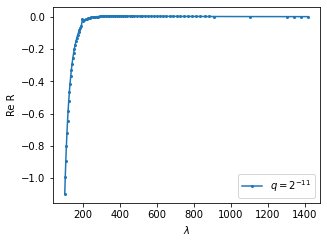

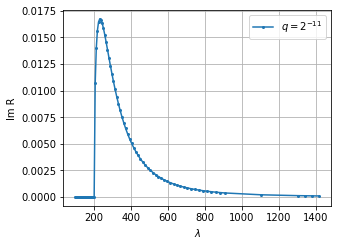

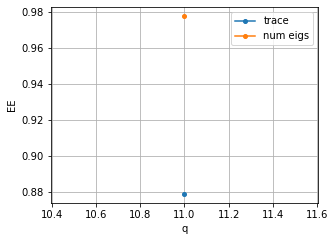

In [163]:

qlist=2**np.array([-11.0])

num_eigs = np.zeros(len(qlist))
tr_rT = np.zeros(len(qlist))
vN_ent = np.zeros(len(qlist))

fig1=plt.figure(1,figsize=(4.8,3.6))
ax1 = fig1.add_subplot()
fig2=plt.figure(2,figsize=(4.8,3.6))
ax2 = fig2.add_subplot()
for i_q in range(len(qlist)):
    q=qlist[i_q]
    if mu==2:
        if np.log2(q)<-7:
            N_lmbda=100
            f1= 'lq_%d_Nl_%d.npz' % (np.log2(q),N_lmbda)
        else:
            N_lmbda=100
            f1= 'q_%.3f_Nl_%d.npz' % (q,N_lmbda)
    else:
        f1= 'lq_mu_%.2f_%d_Nl_%d.npz' % (mu,np.log2(q),N_lmbda)
    out_dir = 'canonical_ent/' 
    fname = out_dir+f1
    if path.exists(fname):
        npzfile = np.load(fname)
        R_re=npzfile['R_re']
        R_im=npzfile['R_im']
        lmbda_re=npzfile['lmbda_re']
        lmbda_im=npzfile['lmbda_im']
    
#     inds= inds_dict['%d' % (i_q)]
                         
    inds= np.argwhere(np.abs(lmbda_im)<1e-4)
    ax1.plot(lmbda_re[inds]/(1+q),R_re[inds],'o-',markersize=2,label='$q=2^{%d}$' % np.log2(q))
    ax2.plot(lmbda_re[inds]/(1+q),np.abs(R_im[inds]),'o-',markersize=2,label='$q=2^{%d}$' % np.log2(q))
    
    num_eigs[i_q]= np.trapz(np.abs(R_im[inds]),x=lmbda_re[inds],axis=0)/pi
    tr_rT[i_q]= 1/(q*Z1)*np.trapz(np.abs(R_im[inds])*lmbda_re[inds],x=lmbda_re[inds],axis=0)/pi
    vN_ent[i_q]= -1/(q*Z1)*np.trapz(np.abs(R_im[inds])*np.abs(lmbda_re[inds])*np.log(np.abs(lmbda_re[inds])),x=lmbda_re[inds],axis=0)/pi

ax1.set_ylabel('Re R')
ax1.set_xlabel('$\lambda$')
ax1.legend()
ax2.set_ylabel('Im R')
ax2.set_xlabel('$\lambda$')
# ax2.set_ylim(-.1,1)
ax2.legend()
plt.grid()
plt.show()


plt.figure(figsize=(4.8,3.6))
# plt.plot(-np.log2(qlist),vN_ent,'o-',markersize=4,label='EE')
plt.plot(-np.log2(qlist),tr_rT,'o-',markersize=4,label='trace')
plt.plot(-np.log2(qlist),num_eigs,'o-',markersize=4,label='num eigs')
plt.ylabel('EE')
plt.xlabel('q')
plt.grid()
plt.legend()
plt.show()


In [161]:
print(10**3.1)

1258.9254117941675
